# Real and fake news classification made by Alexandre Olivier and Cedric Viret

# Methodology

- **0) Part Zero: Cleaning the data, creating and applying NTLK pre-processing methods of both title and text**
<br>

- **1) First Analysis: we analysed title and text separately and predict from both their in sample results using SGDClassifier**<br>

- **2) Second Analysis: we combine title and text together**
    - 2.1) Base Model1: Naïve Bayes
    - 2.2) Base Model1: Logistic Regression
    - 2.3) Stacking Methods: using SGDClassifier, PassiveAgressive and Linear SVM
    <br>
- **3) Third Analysis: Stemming on top of lemmatized combine features**
    - 3.1) Stacking Methods: using SGDClassifier, PassiveAgressive and Linear SVM
    - 3.2) Out of Sample prediction
    - 3.3) Conclusion and improvement<br>
- **4) Grid Search and Randomized Search: This section is not needed to understand our analysis (but important to find the best models and parameters)**


## Part Zero

#### Import libraries


In [26]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
pd.set_option("max_columns", None)

import nltk

import gc
gc.collect()

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier,PassiveAggressiveClassifier
from sklearn.model_selection import cross_val_score,KFold
from xgboost import XGBClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')

#### Import Data

In [27]:
train = pd.read_csv("fake_or_real_news_training.csv", sep=',')
test = pd.read_csv("fake_or_real_news_test.csv")

In [28]:
#overview of the data
train.head(10)


,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE,NaN,NaN
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE,NaN,NaN
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL,NaN,NaN
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL,NaN,NaN
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL,NaN,NaN


In [29]:
print("Inital training shape:",train.shape)
print("Inital test shape:",test.shape)

#check unique id train and test
if len(train.ID.unique())==train.shape[0]:
    print("ID for train is unique and can be dropped")
else:
    print("ID for train is NOT unique and cannot be dropped")
    
#same for test
if len(test.ID.unique())==test.shape[0]:
    print("ID for test is unique and can be dropped")
else:
    print("ID for test is NOT unique and cannot be dropped")

#checking X1 and X2
for col in ['X1','X2']:
    if len(train[train.loc[:,col].isnull()==True])==train.shape[0]:
        print(col, 'can be dropped')
    else:
        print(col,"cannot be dropped")

Inital training shape: (3999, 6)
Inital test shape: (2321, 3)
ID for train is unique and can be dropped
ID for test is unique and can be dropped
X1 cannot be dropped
X2 cannot be dropped


#### Checking X1 and X2
We noticed that when reading the files, some of the title,text and label data is pushed up to the last two columns. As such, we need to do some transformation in order to put everything back where it should be.

There are two cases we needed to distinguish. 
First one is when the data is shifted in X1. In this case, we noticed that the full title is located in the title and the text column. The full text is hence located in the label column and the labels in the X1 column. Thus, we need to shift back the data as follows:

In [30]:
#set a new df for the values that are not NAn for X1 or X2
uncompleted_x1 = train[(train.X1.isnull()!=True) & (train.X2.isnull()==True)]
uncompleted_x1.head(5)


,ID,title,text,label,X1,X2
192,599,Election Day: No Legal Pot In Ohio,Democrats Lose In The South,Election Day: No Legal Pot In Ohio; Democrats ...,REAL,NaN
308,10194,Who rode it best? Jesse Jackson mounts up to f...,Leonardo DiCaprio to the rescue?,Who rode it best? Jesse Jackson mounts up to f...,FAKE,NaN
382,356,Black Hawk crashes off Florida,human remains found,(CNN) Thick fog forced authorities to suspend ...,REAL,NaN
660,2786,Afghanistan: 19 die in air attacks on hospital,U.S. investigating,(CNN) Aerial bombardments blew apart a Doctors...,REAL,NaN
889,3622,Al Qaeda rep says group directed Paris magazin...,US issues travel warning,A member of Al Qaeda's branch in Yemen said Fr...,REAL,NaN


In [31]:
#replace missing values
title = [col1 + col2 for col1,col2 in zip(uncompleted_x1.title, uncompleted_x1.text)] #concatenate the title and text together to get full title
label = [lab for lab in uncompleted_x1.X1] #get the label
text = [lab for lab in uncompleted_x1.label] #get the text

for i,tit,tex,lab in  zip(uncompleted_x1.index.tolist(), title,text,label):
     train.iloc[i,1], train.iloc[i,2],train.iloc[i,3] = tit,tex,lab
        
#check
#for i in uncompleted_x1.index.tolist():
#    print(i,len(train.iloc[i,1]), len(train.iloc[i,2]), len(train.iloc[i,3]), len(train.iloc[i,4]))
    
print('Amount of row changed',len(uncompleted_x1.index.tolist()))

Amount of row changed 31


The second case is when the data is pushed all the way to the last column X2. We identified only two such case and similarly as for the first case, we execute the same transformation. The difference here is that the full title is split across title, text and label, and the last two column contain the text and label respectively.

In [32]:
uncompleted_x2 = train[train.X2.isnull()!=True]
uncompleted_x2.head()

,ID,title,text,label,X1,X2
2184,9,Planned Parenthood’s lobbying effort,pay raises for federal workers,and the future Fed rates,PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE....,REAL
3537,6268,Chart Of The Day: Since 2009—–Recovery For The 5%,Stagnation for the 95%,Chart Of The Day: Since 2009 Recovery For The 5%,Stagnation for the 95%,FAKE


In [33]:
uncompleted_x2 = train[train.X2.isnull()!=True]
uncompleted_x2.head()

title = [col1 + col2+ col3 for col1,col2,col3 in zip(uncompleted_x2.title, uncompleted_x2.text, uncompleted_x2.label)]

#manual transformation
train.iloc[2184,1] = title[0]
train.iloc[2184,2] = train.iloc[2184,4]
train.iloc[2184,3] = train.iloc[2184,5]

train.iloc[3537,1] = title[1]
train.iloc[3537,2] = train.iloc[3537,4]
train.iloc[3537,3] = train.iloc[3537,5]


In [34]:
train.iloc[uncompleted_x2.index.tolist(),:] # here we add back the data

,ID,title,text,label,X1,X2
2184,9,Planned Parenthood’s lobbying effort pay raise...,PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE....,REAL,PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE....,REAL
3537,6268,Chart Of The Day: Since 2009—–Recovery For The...,Stagnation for the 95%,FAKE,Stagnation for the 95%,FAKE


In [35]:
len(train[train.loc[:,'X1'].isnull()==True])

3966

In [36]:
#drop X1 and X2
train.drop(["X1","X2"], inplace = True, axis = 1)

#save train and test id
train_id = train.ID
test_id = test.ID

#drop train and test id
train.drop(["ID"], inplace = True, axis = 1)
test.drop(["ID"], inplace = True, axis = 1)

#print shape
print(train.shape)
print(test.shape)


(3999, 3)
(2321, 2)


#### Understand target - balanced class

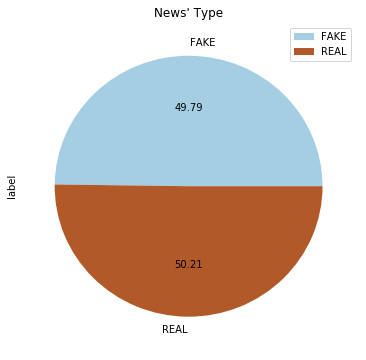

In [37]:
train.groupby('label')['label'].count().plot.pie(figsize=(6,6), autopct='%.2f', legend=True, title="News' Type",colormap ="Paired")


**It is a binary classification problem:**
Let's recode the FAKE/REAL label

In [38]:
#create traget
y_train = pd.DataFrame(train.label.apply(lambda x: 1 if x == "FAKE" else 0), columns=['label'])

#create features
features = train.iloc[:,0:2]
print("target shape:",y_train.shape,"and features shape:",features.shape)

target shape: (3999, 1) and features shape: (3999, 2)


#### NLTK

In [39]:
#creating function
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer,WordNetLemmatizer
from nltk import pos_tag,DefaultTagger,RegexpTagger
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag
#CountVectorizer,RegexpStemmer,DefaultTagger

import string

#tokenized
def word_tokenized(text):
    return word_tokenize(text)

#stop word
def stop_word(text, stopword,split):
    if split is True:
        text = [word for word in text.split() if word not in stopword]
    else:
        text = [word for word in text if word not in stopword]
    return " ".join(text)


def stem(text, stem, split):
    if split is True:
        text = [stem.stem(word) for word in text.split()]
    else:
         text = [stem.stem(word) for word in text]
    return " ".join(text)

#lemmatazing
from nltk.stem import WordNetLemmatizer
def lem(text, split):
    if split is True:
        text = [WordNetLemmatizer().lemmatize(word) for word in text.split()]
    else:
         text = [WordNetLemmatizer().lemmatize(word) for word in text]
    return " ".join(text)

#POS

part = {
    'N' : 'n',
    'V' : 'v',
    'J' : 'a',
    'S' : 's',
    'R' : 'r'
}

wnl = WordNetLemmatizer()

def convert_tag(penn_tag):
    '''
    convert_tag() accepts the **first letter** of a Penn part-of-speech tag,
    then uses a dict lookup to convert it to the appropriate WordNet tag.
    '''
    if penn_tag in part.keys():
        return part[penn_tag]
    else:
        # other parts of speech will be tagged as nouns
        return 'n'
    
def tag_and_lem(element, tokenized):
    '''
    tag_and_lem() accepts a string, tokenizes, tags, converts tags,
    lemmatizes, and returns a string
    '''
    # list of tuples [('token', 'tag'), ('token2', 'tag2')...]
    
    if tokenized is True:
        sent = pos_tag((element)) # must tag in context
        return ' '.join([wnl.lemmatize(sent[k][0], convert_tag(sent[k][1][0]))
                    for k in range(len(sent))])
    else:
        sent = pos_tag(word_tokenize(element)) # must tag in context
        return ' '.join([wnl.lemmatize(sent[k][0], convert_tag(sent[k][1][0]))
                    for k in range(len(sent))])

### NLTK Methodolgy<br>
We applied different NLTK text processing methods from simple tokenization to lemmatizing on both title and text columns - we saved each individual transformation as a new feature of the dataset. <br>
**Our assumption was that to find a good model title and text might required different NLTK processing**.


### Focusing on Title

#### Tokenized features

In [40]:
#tokenized title in lower case
features['t0'] = features.title.apply(lambda x: word_tokenized(x.lower()))

#### Stop word

In [41]:
from nltk.corpus import stopwords
#stopword with punctionation lower
stopwords = stopwords.words('english')
features['t0t1']=features.t0.apply(lambda x: stop_word(x, stopwords,False))

features.t0t1.head(2)

0                                 smell hillary ’ fear
1    watch exact moment paul ryan committed politic...
Name: t0t1, dtype: object

In [42]:
from nltk.corpus import stopwords
#stopword with punctionation lower
stopwords = stopwords.words('english')+ list(string.punctuation)
features['t0t2']=features.t0.apply(lambda x: stop_word(x, stopwords,False))

features.t0t2.head(2)

0                                 smell hillary ’ fear
1    watch exact moment paul ryan committed politic...
Name: t0t2, dtype: object

#### Part of Speech (POS)

In [43]:
#POS
pos_title = features.t0.apply(lambda x: pos_tag(x))


In [44]:
pos_title[1]

[('watch', 'VB'),
 ('the', 'DT'),
 ('exact', 'JJ'),
 ('moment', 'NN'),
 ('paul', 'NN'),
 ('ryan', 'NN'),
 ('committed', 'VBD'),
 ('political', 'JJ'),
 ('suicide', 'NN'),
 ('at', 'IN'),
 ('a', 'DT'),
 ('trump', 'NN'),
 ('rally', 'NN'),
 ('(', '('),
 ('video', 'NN'),
 (')', ')')]

##### Testing Lemmatizing with POS

In [45]:
lem = features.t0.apply(lambda x: tag_and_lem(x,True)) 

In [46]:
lem[1]

'watch the exact moment paul ryan commit political suicide at a trump rally ( video )'

**We can see that that it is functionning because "committed" has been transformed to "commit"** <br>

So far, we only have made 3 transformations:
-	Tokenized the text
-	Tokenized the text and remove the stop word
-	Tokenized the text and remove the stop including the punctuation
<br>

The next step is to apply Stemming on Lemmatizing on the above listed transformation


#### Stemming and Lemmatizing

In [47]:
#set two different stemmer
PS = PorterStemmer()
#SS = SnowballStemmer('english')

##### LOWER CASE TOKENIZER
#stemming on tockenized data
features['t0t3'] = features.t0.apply(lambda x: tag_and_lem(x,True))
features['t0t4'] = features.t0.apply(lambda x: stem(x,PS, False))

#stemining on tockenized data + word stop
features['t0t1t3'] = features.t0t1.apply(lambda x: tag_and_lem(x,False))
features['t0t1t4'] = features.t0t1.apply(lambda x: stem(x,PS, True))

#stemining on tockenized data + word stop + ponctuation stop
features['t0t2t3'] = features.t0t2.apply(lambda x: tag_and_lem(x,False))
features['t0t2t4'] = features.t0t2.apply(lambda x: stem(x,PS, True))


print("lower case")
print(features.t0t3.head(2))
print(features.t0t4.head(2))
print(features.t0t1t3.head(2))
print(features.t0t1t3.head(2))
print(features.t0t2t3.head(2))
print(features.t0t2t3.head(2))



lower case
0                       you can smell hillary ’ s fear
1    watch the exact moment paul ryan commit politi...
Name: t0t3, dtype: object
0                       you can smell hillari ’ s fear
1    watch the exact moment paul ryan commit polit ...
Name: t0t4, dtype: object
0                                 smell hillary ’ fear
1    watch exact moment paul ryan commit political ...
Name: t0t1t3, dtype: object
0                                 smell hillary ’ fear
1    watch exact moment paul ryan commit political ...
Name: t0t1t3, dtype: object
0                                 smell hillary ’ fear
1    watch exact moment paul ryan commit political ...
Name: t0t2t3, dtype: object
0                                 smell hillary ’ fear
1    watch exact moment paul ryan commit political ...
Name: t0t2t3, dtype: object


### Focusing on Text<br>
We applied the same NLTK transfromations made on the title to the text.

In [48]:
#tokenized text in lower case
features['tt0'] = features.text.apply(lambda x: word_tokenized(x.lower()))

In [49]:
from nltk.corpus import stopwords

#stopword + lower case
stopwords = stopwords.words('english')
features['tt0tt1']=features.tt0.apply(lambda x: stop_word(x,stopwords,False))
features.tt0tt1.head(2)

0    daniel greenfield , shillman journalism fellow...
1    google pinterest digg linkedin reddit stumbleu...
Name: tt0tt1, dtype: object

In [50]:
from nltk.corpus import stopwords
#stopword with punctionation lower case
stopwords = stopwords.words('english')+ list(string.punctuation)
features['tt0tt2']=features.tt0.apply(lambda x: stop_word(x, stopwords,False))

features.tt0tt2.head(2)

0    daniel greenfield shillman journalism fellow f...
1    google pinterest digg linkedin reddit stumbleu...
Name: tt0tt2, dtype: object

In [51]:
##### LOWER CASE TOKENIZER
#stemming on tockenized data
features['tt0tt3'] = features.tt0.apply(lambda x: tag_and_lem(x,True))
gc.collect()
features['tt0tt4'] = features.tt0.apply(lambda x: stem(x,PS, False))
print(features.tt0tt3.head(2))
print(features.tt0tt4.head(2))
gc.collect()

#stemining on tockenized data + word stop
features['tt0tt1tt3'] = features.tt0tt1.apply(lambda x: tag_and_lem(x,False))
gc.collect()
features['tt0tt1tt4'] = features.tt0tt1.apply(lambda x: stem(x,PS, True))
gc.collect()

print(features.tt0tt1tt3.head(2))
print(features.tt0tt1tt3.head(2))

#stemining on tockenized data + word stop + ponctuation stop
features['tt0tt2tt3'] = features.tt0tt2.apply(lambda x: tag_and_lem(x,False))
gc.collect()

features['tt0tt2tt4'] = features.tt0tt2.apply(lambda x: stem(x,PS, True))
gc.collect()

print(features.tt0tt2tt3.head(2))
print(features.tt0tt2tt3.head(2))

gc.collect()

0    daniel greenfield , a shillman journalism fell...
1    google pinterest digg linkedin reddit stumbleu...
Name: tt0tt3, dtype: object
0    daniel greenfield , a shillman journal fellow ...
1    googl pinterest digg linkedin reddit stumbleup...
Name: tt0tt4, dtype: object
0    daniel greenfield , shillman journalism fellow...
1    google pinterest digg linkedin reddit stumbleu...
Name: tt0tt1tt3, dtype: object
0    daniel greenfield , shillman journalism fellow...
1    google pinterest digg linkedin reddit stumbleu...
Name: tt0tt1tt3, dtype: object
0    daniel greenfield shillman journalism fellow f...
1    google pinterest digg linkedin reddit stumbleu...
Name: tt0tt2tt3, dtype: object
0    daniel greenfield shillman journalism fellow f...
1    google pinterest digg linkedin reddit stumbleu...
Name: tt0tt2tt3, dtype: object


0

In [52]:
#copy features
features_c = features.copy()
gc.collect()


0

#### View of all the features<br>
list of NLTK transformation we applied on the title and text (total 9 NLTK transformation).

- simple tokenization
- tokenization with remove stop words
- tokenization with remove stop words and the punctuation
- lemmatizing on simple tokenization 
- stemming on simple tokenization 
- lemmatizing on tokenization with remove stop words
- stemming on tokenization with remove stop words
- lemmatizing on tokenization with remove stop words and the punctuation
- stemming on tokenization with remove stop words and the punctuation

** “t” features correspond to transformation applied on title and “tt” correspond to transformation apply on the text. So the encoding for title would be something like: tXtXtX and for title: ttXttXttX with X corresponding to a number. More details below: **




In [53]:
gc.collect()
features.head(1)

,title,text,t0,t0t1,t0t2,t0t3,t0t4,t0t1t3,t0t1t4,t0t2t3,t0t2t4,tt0,tt0tt1,tt0tt2,tt0tt3,tt0tt4,tt0tt1tt3,tt0tt1tt4,tt0tt2tt3,tt0tt2tt4
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...","[you, can, smell, hillary, ’, s, fear]",smell hillary ’ fear,smell hillary ’ fear,you can smell hillary ’ s fear,you can smell hillari ’ s fear,smell hillary ’ fear,smell hillari ’ fear,smell hillary ’ fear,smell hillari ’ fear,"[daniel, greenfield, ,, a, shillman, journalis...","daniel greenfield , shillman journalism fellow...",daniel greenfield shillman journalism fellow f...,"daniel greenfield , a shillman journalism fell...","daniel greenfield , a shillman journal fellow ...","daniel greenfield , shillman journalism fellow...","daniel greenfield , shillman journal fellow fr...",daniel greenfield shillman journalism fellow f...,daniel greenfield shillman journal fellow free...


Since we have applied all NLTK preprocessing transformation we can get rid of the initial columns (title and text) they are not useful for the rest of our analysis and modelling.

In [54]:
#get the title
remove_col = ['title','text'] #remove initial data
features.drop(remove_col, axis =1, inplace = True)

In [55]:
features.columns

Index(['t0', 't0t1', 't0t2', 't0t3', 't0t4', 't0t1t3', 't0t1t4', 't0t2t3',
       't0t2t4', 'tt0', 'tt0tt1', 'tt0tt2', 'tt0tt3', 'tt0tt4', 'tt0tt1tt3',
       'tt0tt1tt4', 'tt0tt2tt3', 'tt0tt2tt4'],
      dtype='object')

In [56]:
features.shape

(3999, 18)

In [57]:
#getting the title and text columns
title = features.iloc[:,:9].columns
text = features.iloc[:,9:].columns

In [58]:
#Changing t0 and tt0 type to string
features['t0'] = str(features['t0'])
features['tt0'] = str(features['tt0'])

## First Analysis <br>

We analysed separately the text and title

#### Focusing on Title

In [59]:
#kfold strategy
kfold = KFold(n_splits=3,random_state=42,shuffle=False)

In [60]:
model, score, para = [],{},{}

#final_grid = GridSearchCV(final_pipe, para, scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
if __name__ == "__main__":
    for i in title:
        #Create a pipeline
        final_pipe = Pipeline([('vc', CountVectorizer()),
                          ('tt', TfidfTransformer()),
                          ('SDG', SGDClassifier())])

        #Set parameters
        para = {'vc__ngram_range': ((1, 1), (1, 2)), 
        'tt__use_idf': (True, False),
        }

        #Randomized
        final_grid = GridSearchCV(final_pipe, para ,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=0, pre_dispatch='2*n_jobs')
        final_grid.fit(features.loc[:,i],y_train.values)
        
       
        #Append
        model.append(i)
        score[i] = final_grid.best_score_ 
        para[i] = final_grid.best_params_
        print("loading done: {}".format(model))
        gc.collect()

loading done: ['t0']
loading done: ['t0', 't0t1']
loading done: ['t0', 't0t1', 't0t2']
loading done: ['t0', 't0t1', 't0t2', 't0t3']
loading done: ['t0', 't0t1', 't0t2', 't0t3', 't0t4']
loading done: ['t0', 't0t1', 't0t2', 't0t3', 't0t4', 't0t1t3']
loading done: ['t0', 't0t1', 't0t2', 't0t3', 't0t4', 't0t1t3', 't0t1t4']
loading done: ['t0', 't0t1', 't0t2', 't0t3', 't0t4', 't0t1t3', 't0t1t4', 't0t2t3']
loading done: ['t0', 't0t1', 't0t2', 't0t3', 't0t4', 't0t1t3', 't0t1t4', 't0t2t3', 't0t2t4']


In [61]:
#get the model score
score_title = pd.DataFrame.from_dict({'score':score})
score_title.sort_values('score', ascending=False)

,score
t0t2t3,0.804451
t0t2t4,0.802951
t0t4,0.801450
t0t3,0.801200
t0t1t4,0.800950
t0t2,0.800450
t0t1t3,0.799450
t0t1,0.794449
t0,0.511378


#### Focusing on text

In [62]:
model, score, para = [],{},{}

#final_grid = GridSearchCV(final_pipe, para, scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
if __name__ == "__main__":
    for i in text:
        #Create a pipeline
        final_pipe = Pipeline([('vc', CountVectorizer()),
                          ('tt', TfidfTransformer()),
                          ('SDG', SGDClassifier())])

        #Set parameters
        para = {'vc__ngram_range': ((1, 1), (1, 2)), 
        'tt__use_idf': (True, False),
        }

        #Randomized
        final_grid = GridSearchCV(final_pipe, para ,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=0, pre_dispatch='2*n_jobs')
        final_grid.fit(features.loc[:,i],y_train.values)
        
       
        #Append
        model.append(i)
        score[i] = final_grid.best_score_ 
        para[i] = final_grid.best_params_
        print("loading done: {}".format(model))
        gc.collect()

loading done: ['tt0']
loading done: ['tt0', 'tt0tt1']
loading done: ['tt0', 'tt0tt1', 'tt0tt2']
loading done: ['tt0', 'tt0tt1', 'tt0tt2', 'tt0tt3']
loading done: ['tt0', 'tt0tt1', 'tt0tt2', 'tt0tt3', 'tt0tt4']
loading done: ['tt0', 'tt0tt1', 'tt0tt2', 'tt0tt3', 'tt0tt4', 'tt0tt1tt3']
loading done: ['tt0', 'tt0tt1', 'tt0tt2', 'tt0tt3', 'tt0tt4', 'tt0tt1tt3', 'tt0tt1tt4']
loading done: ['tt0', 'tt0tt1', 'tt0tt2', 'tt0tt3', 'tt0tt4', 'tt0tt1tt3', 'tt0tt1tt4', 'tt0tt2tt3']
loading done: ['tt0', 'tt0tt1', 'tt0tt2', 'tt0tt3', 'tt0tt4', 'tt0tt1tt3', 'tt0tt1tt4', 'tt0tt2tt3', 'tt0tt2tt4']


In [63]:
#get the model score
score_text = pd.DataFrame.from_dict({'score':score})
score_text.sort_values('score', ascending=False)

,score
tt0tt4,0.929232
tt0tt3,0.928732
tt0tt1tt4,0.926482
tt0tt1tt3,0.925981
tt0tt2,0.925481
tt0tt2tt3,0.925231
tt0tt2tt4,0.923481
tt0tt1,0.922231
tt0,0.511378


### First conclusion<br>
When analysed separately the text has more predictive power that title. The best model for **text** has an accuracy score of around **92.9%**, while **title** best accuracy score is only at **80%**.<br>
It is even more interesting to see that NLTK pipeline provide a different best score for different features:
-  Simple tokenization without stop words gives the best results for text (tt0tt4)
-  Stemming on tokenization without stop words and punctuation gives best results for title (t0t2t3) <br>

<br>**With that data insight we decided to continue further our analysis be grouping the text and title together.**


### Combining title and text

In [64]:
features.columns

Index(['t0', 't0t1', 't0t2', 't0t3', 't0t4', 't0t1t3', 't0t1t4', 't0t2t3',
       't0t2t4', 'tt0', 'tt0tt1', 'tt0tt2', 'tt0tt3', 'tt0tt4', 'tt0tt1tt3',
       'tt0tt1tt4', 'tt0tt2tt3', 'tt0tt2tt4'],
      dtype='object')

In [65]:
title_rework = title.drop('t0')
text_reword = text.drop('tt0')
print(title_rework)
print(text_reword)

Index(['t0t1', 't0t2', 't0t3', 't0t4', 't0t1t3', 't0t1t4', 't0t2t3', 't0t2t4'], dtype='object')
Index(['tt0tt1', 'tt0tt2', 'tt0tt3', 'tt0tt4', 'tt0tt1tt3', 'tt0tt1tt4',
       'tt0tt2tt3', 'tt0tt2tt4'],
      dtype='object')


We removed columns ‘t0’ and ‘tt0’ (simple tokenization) because they are not relevant for the rest of our analysis - independently these transformations scored the lower for both title and text (around 50%).

<br>
**As we already discovered on the first analysis, title and text might need different NLTK processing to find best results possible… Therefore, we decided to combine all the NLTK transformation for the title and text together. Hence, we end up with: 64 possible combinations of title and text (8 different NLTK transformations on title * 8 different NLTK transformations on text). **


In [66]:
#combining title and text together
combine2 = [features[[i,j]].apply(lambda x: ' '.join(x), axis = 1) for i in title_rework for j in text_reword]
gc.collect()

0

In [67]:
len(combine2)

64

To find the best NLTK pre-processing methods in our 64 possible combinations of title and text we ran a grid search with grid parameters:
**-unigram, bigram and trigram** for **“count vectorizer” ** and **“TFIDF transform” **
**We apply this grid search with algorithms (Logistic Regression, SGDclassifier, PassiveAgressiveClassifier and Linear SVM)**

The results of the analysis can be find on section “Ad hoc” at the end of this notebook:

<br>
**How to understand the matrix**: t01 and tt0tt1 are the same NLTK pre-processing apply on title (t0) and text (tt0), corresponding to NLTK transformation: tokenized without stops word. So “M0” in the matrix refers to the above-mentioned transformation.<br>
Applying that logic we have, for instance, “M31” equal to the title feature lemmatized on tokenized words and the text features stemmed with tokenized words without stop words and punctuation.

In the below image you can find  all the models combinations – we highlighted the top3 score for each algorithm

<img src="Final_matrix.png" />


We can see a pattern in the columns “tt0tt3 ” and “tt0tt4” which correspond to lemmatizing on **simple tokenization and stemming on simple tokenization for the text**.
While for the **title** there is a clear pattern related to the “t0t2t3” transformation which correspond to **lemmatizing on tokenization without stop words and punctuation**


## Second Analysis

### Filtering on best NLTK pre-processing

With the insights we get from the previous steps we decided to narrow down our possible combination of features. We only considered the best 3 results of the 2 models with the highest first score (PassiveAgressive and SDGClassifier). See the below image: <br>

<img src="Final_top3.png">


**Hence, reducing NLTK pre-processing combination from 64 to only 6. These 6 combinations will be used for our base model.**<br>

<br>Note: the score difference between the 4 algorithms top 3 (as showed on the above image) was minimal (max difference of 1%).


In [68]:
#getting the best NLTK pre-preocessing
filter_models = []
for i in [27,53,35,26,3,50]:     #best model score 
    filter_models.append(combine2[i])
    gc.collect

### Base model 1: Naive bayes

In [69]:
model, score,vc, tf = [],{},{},{}

if __name__ == "__main__":
    for i in range(0,len(filter_models)):

        final_pipe = Pipeline([('vc', CountVectorizer()),
                                  ('tt', TfidfTransformer()),
                                  ('ML', MultinomialNB())])
        #Set parameters
        para = {'vc__ngram_range': ((1, 1), (1, 2)), 
        'tt__use_idf': (True, False)
        
        }

        #Randomized
        base_grid = GridSearchCV(final_pipe,para,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=0, pre_dispatch='2*n_jobs')
        base_grid.fit(filter_models[i],y_train.values)
        
         #Append
        model.append(i)
        score[i] = base_grid.best_score_
        vc[i] = (base_grid.best_params_['vc__ngram_range'])
        tf[i] = (base_grid.best_params_['tt__use_idf'])
       
        print("loading done:for model: {}".format(model))
        gc.collect()

loading done:for model: [0]
loading done:for model: [0, 1]
loading done:for model: [0, 1, 2]
loading done:for model: [0, 1, 2, 3]
loading done:for model: [0, 1, 2, 3, 4]
loading done:for model: [0, 1, 2, 3, 4, 5]


In [70]:
base_model = pd.concat([pd.DataFrame(pd.Series(model, name = "Model")),
                        pd.DataFrame(pd.Series(vc,name = 'VC')),
                          pd.DataFrame(pd.Series(tf,name = 'TF')),
                         pd.DataFrame(pd.Series(score,name = 'Score'))],axis = 1)

#df
base_model.sort_values('Score',ascending=False)

,Model,VC,TF,Score
1,1,"(1, 1)",False,0.819955
0,0,"(1, 1)",False,0.778195
2,2,"(1, 1)",False,0.777694
4,4,"(1, 1)",False,0.775694
5,5,"(1, 1)",True,0.763691
3,3,"(1, 1)",True,0.762691


### Base model 2: Logistic Regression


In [71]:
model, score,vc, tf = [],{},{},{}

if __name__ == "__main__":
    for i in range(0,len(filter_models)):

        final_pipe = Pipeline([('vc', CountVectorizer()),
                                  ('tt', TfidfTransformer()),
                                  ('ML', LogisticRegression())])
        #Set parameters
        para = {'vc__ngram_range': ((1, 1), (1, 2)), 
        'tt__use_idf': (True, False)
        
        }

        #Randomized
        base_grid = GridSearchCV(final_pipe,para,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=0, pre_dispatch='2*n_jobs')
        base_grid.fit(filter_models[i],y_train.values)
        
         #Append
        model.append(i)
        score[i] = base_grid.best_score_
        vc[i] = (base_grid.best_params_['vc__ngram_range'])
        tf[i] = (base_grid.best_params_['tt__use_idf'])
       
        print("loading done:for model: {}".format(model))
        gc.collect()

loading done:for model: [0]
loading done:for model: [0, 1]
loading done:for model: [0, 1, 2]
loading done:for model: [0, 1, 2, 3]
loading done:for model: [0, 1, 2, 3, 4]
loading done:for model: [0, 1, 2, 3, 4, 5]


In [72]:
base_model2 = pd.concat([pd.DataFrame(pd.Series(model, name = "Model")),
                        pd.DataFrame(pd.Series(vc,name = 'VC')),
                          pd.DataFrame(pd.Series(tf,name = 'TF')),
                         pd.DataFrame(pd.Series(score,name = 'Score'))],axis = 1)

#df
base_model2.sort_values('Score',ascending=False)

,Model,VC,TF,Score
1,1,"(1, 2)",True,0.905226
2,2,"(1, 1)",True,0.902726
0,0,"(1, 1)",True,0.902476
3,3,"(1, 1)",True,0.902476
5,5,"(1, 1)",True,0.902226
4,4,"(1, 1)",True,0.900725


We can easily see that the best logistic regression (90%) outperformed the Naïve Bayes model (82%) – But logistic regression best score is lower that SDGClassifier score when performed only on Title (90% vs 92%). This lead to the conclusion that we should use different algorithms to increase our In-Sample score.<br>

**After running a grid search on our 6 remaining possible combinations of NLTK pre-processing on text and title, we decided to select M27 which correspond to apply stemming on simple tokenization for both title and text (for details see further down in the notebook Extreme Grid Search section) .**


In [73]:
#final model
X_train = filter_models[0]

note: filter_models[0] equal to M27 in the 64 possible combination of NLTK transformation.

### Stacking Model: Voting classifier

For our element ensemble: Stacking (Voting Classifier)  with used PassiveAgressive, SGDClassifier and Linear SVM (we discarded Logistic Regression and Naive Bayes because none of them get a score higher of 92%).

In [74]:
#Create model Framework
cf1 = Pipeline([('vc', CountVectorizer(ngram_range=(1,2))),
                                  ('tt', TfidfTransformer()),
                                  ('PA', PassiveAggressiveClassifier(C=150))])

cf2 = Pipeline([('vc', CountVectorizer(ngram_range=(1,2))),
                                  ('tt', TfidfTransformer()),
                                  ('SGD', SGDClassifier(penalty='elasticnet'))])

cf3 = Pipeline([('vc', CountVectorizer(ngram_range=(1,2))),
                                  ('tt', TfidfTransformer()),
                                  ('LSVM', LinearSVC(C=300))])

#list of estimator with names
estimators = [('PA', cf1),('SGD', cf2),('LSVM', cf3)]

#Voting Classifier
ecf = VotingClassifier(estimators= estimators,
                          voting='hard',            
                          weights=None,
                          n_jobs=1,
                          flatten_transform=None)

#Display Voting Classifier score
for clf, label in zip([cf1, cf2,cf3, ecf], ['PA', 'SDG', 'LSVM', 'Ensemble']):
       scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='accuracy')
       print("Accuracy: {} {}".format(scores.mean(), label))
#Voting Classifier fit
#vc = ecf.fit(X_train, y_train)

#Voting Classifier predict
#vc.predict(X_test)

Accuracy: 0.932983245811453 PA
Accuracy: 0.9294823705926482 SDG
Accuracy: 0.9344836209052264 LSVM
Accuracy: 0.9342335583895974 Ensemble


In [75]:
#Voting Classifier fit
vc = ecf.fit(X_train, y_train)


### Second conclusion
Applying voting classifier (element ensemble) increase our score from 92% to 93.5%. Let ‘see if we can improve our score with a last analysis requiring NLTK pre-processing.

## Third Analysis


M50 correspond to lemmatizing on tokenization with remove stop words and the punctuation for the title and lemmatizing on simple tokenization for the text. <br>** Thus, we can apply some Stemming methods on top of lemmatized features.**

In [76]:
#getting M50 from filter_model
m50 = filter_models[5]

#glimpse at M50
m50[1][:450]

'watch exact moment paul ryan commit political suicide trump rally video google pinterest digg linkedin reddit stumbleupon print delicious pocket tumblr there be two fundamental truth in this world : paul ryan desperately want to be president . and paul ryan will never be president . today prove it . in a particularly staggering example of political cowardice , paul ryan re-re-re-reversed course and announce that he be back on the trump train afte'

In [77]:
m50_stem = m50.apply(lambda x: stem(x,PS,True))

In [78]:
m50_stem[1][:450]

'watch exact moment paul ryan commit polit suicid trump ralli video googl pinterest digg linkedin reddit stumbleupon print delici pocket tumblr there be two fundament truth in thi world : paul ryan desper want to be presid . and paul ryan will never be presid . today prove it . in a particularli stagger exampl of polit cowardic , paul ryan re-re-re-revers cours and announc that he be back on the trump train after all . thi be an aboutfac from wher'

**Stemming on top of lemmatized works as expected, we have “president” that become “presid”.**

In [80]:
#len check
len(m50_stem)

3999

### Gird search
apply grid search to fnd the best paramters per algorthim

##### SGDClassifier

In [201]:
final_pipe = Pipeline([('vc', CountVectorizer()),
                                  ('tt', TfidfTransformer()),
                                  ('SGD', SGDClassifier())])
#Set parameters
para = {'vc__ngram_range': ((1, 1), (1, 2),(1,3)), 
'tt__use_idf': (True, False),
'SGD__penalty':('l2','l1','elasticnet')

}

#Randomized
base_grid = GridSearchCV(final_pipe,para,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
base_grid.fit(m50_stem,y_train.values)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   33.4s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  6.9min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.8min
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed: 10.5min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vc', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_a...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'vc__ngram_range': ((1, 1), (1, 2), (1, 3)), 'tt__use_idf': (True, False), 'SGD__penalty': ('l2', 'l1', 'elasticnet')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=10)

In [202]:
print(base_grid.best_score_)
print(base_grid.best_params_)

0.929982495624
{'SGD__penalty': 'l2', 'tt__use_idf': True, 'vc__ngram_range': (1, 2)}


##### PassiveAgressive

In [205]:
final_pipe = Pipeline([('vc', CountVectorizer()),
                                  ('tt', TfidfTransformer()),
                                  ('PA', PassiveAggressiveClassifier())])
#Set parameters
para = {'vc__ngram_range': ((1, 1), (1, 2),(1,3)), 
'tt__use_idf': (True, False),
'PA__C':(.1,.8,2,5)

}

#Randomized
base_grid = GridSearchCV(final_pipe,para,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
base_grid.fit(m50_stem,y_train.values)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   10.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   38.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  6.8min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.5min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 10.5min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 12.7min
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed: 13.9min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vc', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_a...   n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'vc__ngram_range': ((1, 1), (1, 2), (1, 3)), 'tt__use_idf': (True, False), 'PA__C': (0.1, 0.8, 2, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=10)

In [206]:
print(base_grid.best_score_)
print(base_grid.best_params_)

0.934483620905
{'PA__C': 2, 'tt__use_idf': True, 'vc__ngram_range': (1, 2)}


##### Linear SVM

In [211]:
final_pipe = Pipeline([('vc', CountVectorizer()),
                                  ('tt', TfidfTransformer()),
                                  ('SVM', LinearSVC())])
#Set parameters
para = {'vc__ngram_range': ((1, 1), (1, 2)), 
'tt__use_idf': (True, False),
'SVM__C':(.5,1,2,5),
#'SVM__penality':('l2','l1')

}

#Randomized
base_grid = GridSearchCV(final_pipe,para,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
base_grid.fit(m50_stem,y_train.values)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   30.4s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   53.8s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  5.6min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vc', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_a...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'vc__ngram_range': ((1, 1), (1, 2)), 'tt__use_idf': (True, False), 'SVM__C': (0.5, 1, 2, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=10)

In [212]:
print(base_grid.best_score_)
print(base_grid.best_params_)

0.935233808452
{'SVM__C': 5, 'tt__use_idf': True, 'vc__ngram_range': (1, 2)}


### Stacking Model2: Voting classifier
Apply voting classifier for the stemmed and lemmatized features.

In [81]:
#Create model Framework
cf12 = Pipeline([('vc', CountVectorizer(ngram_range=(1,2))),
                                  ('tt', TfidfTransformer()),
                                  ('PA', PassiveAggressiveClassifier(C=2))])

cf22 = Pipeline([('vc', CountVectorizer(ngram_range=(1,2))),
                                  ('tt', TfidfTransformer()),
                                  ('SGD', SGDClassifier(penalty='l2'))])

cf32 = Pipeline([('vc', CountVectorizer(ngram_range=(1,2))),
                                  ('tt', TfidfTransformer()),
                                  ('LSVM', LinearSVC(C=5))])

#list of estimator with names
estimators = [('PA', cf1),('SGD', cf2),('LSVM', cf3)]

#Voting Classifier
ecf2 = VotingClassifier(estimators= estimators,
                          voting='hard',            
                          weights=None,
                          n_jobs=1,
                          flatten_transform=None)

#Display Voting Classifier score
for clf, label in zip([cf12, cf22,cf32, ecf2], ['PA', 'SDG', 'LSVM', 'Ensemble']):
       scores = cross_val_score(ecf2, m50_stem, y_train, cv=kfold, scoring='accuracy')
       print("Accuracy: {} {}".format(scores.mean(), label))
#Voting Classifier fit
#vc = ecf.fit(X_train, y_train)

#Voting Classifier predict
#vc.predict(X_test)

Accuracy: 0.935233808452113 PA
Accuracy: 0.9329832458114528 SDG
Accuracy: 0.9324831207801951 LSVM
Accuracy: 0.9344836209052264 Ensemble


In [82]:
#Voting Classifier fit 2
vc2 = ecf2.fit(X_train, y_train)

### Third conclusion

Strangely, applying a stemming method on top of lemmatized features did not improve our score <br>

** For our submission, we decided to use the voting classifier of the third analysis. The main reason is that we only apply a cross validation technique with 3 folds (1333 row per fold) which most probably is no preventing enough overfitting (1). Thus, applying a more generalized approach we might have a better Out of Sample result. **
<br>

(1)	Because we made 64 possible combinations of title and text we needed to have a cross validation strategy that would converge "fast" (the number of fold influences the amount of time an algorithm takes to converge).




### Apply best NLTK transformation on the test data

In [83]:
#on titile
from nltk.corpus import stopwords
#stopword with punctionation lower
stopwords = stopwords.words('english')+ list(string.punctuation)

test['title_t'] = test.title.apply(lambda x: stem(tag_and_lem(stop_word(word_tokenized(x.lower()),stopwords,False),False),PS,True))


In [84]:
#in text
test['text_t'] =  test.text.apply(lambda x: stem(tag_and_lem(word_tokenized(x.lower()),True),PS,True))


In [86]:
#overview
test.head(2)

,title,text,title_t,text_t
0,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,septemb new home sale rise——-back 1992 level,septemb new home sale rise back to 1992 level ...
1,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,obamacar doomsday cult ca n't admit 's wrong,but when congress debat and pass the patient p...


#### Combine title and text for test dataset

In [87]:
X_test = test[['title_t','text_t']].apply(lambda x: ' '.join(x), axis = 1)

In [88]:
#making sure that the combine title and testare correct
X_test[1]

"obamacar doomsday cult ca n't admit 's wrong but when congress debat and pass the patient protect and afford care act in 2009 and 2010 , oppon be nearli unifi in offer grim keech-lik predict . with obamacar now in full effect , and the economi on a decid upsw , the dour prognost be start to look like keech 's fli saucer . at least if you believ the data . a look at festing 's theori , though , can explain whi that wo n't matter , and whi american can expect a continu drumbeat of doom , even a the propheci fail . “ it certainli have not have the bale effect the critic be predict , ” say paul van de water , a senior fellow at the center on budget and polici prioriti who support the law , but never think it would have much econom impact . “ on balanc it may be a modest plu , to the extent that it have contribut to the slowdown of growth in health care costs. ” but that 's not how capitol hill ’ s gloomsday cult see it . inde , tri get ani of them to admit the afford care act job slaughte

**Stemming on top of lemmatization worked, in the second line there is:  “economi…decid”**

#### Out of Sample prediction

In [89]:
pred = vc2.predict(X_test)

In [90]:
#Change the binary prediction to real or fake
prediction = ["FAKE" if x == 1  else "REAL" for x in pred]


In [97]:
#check

for i,j in zip(pred,prediction):
    if i == 1 and j == "FAKE" or i == 0 and j == "REAL":
        a = "no misplace values"
    else:
        a = "MISPLACED VALUES"
print(a)

no misplace values


In [101]:
#last check before submitting
print('test lenght: ',test.shape[0])
print('prediction lenght: ',len(prediction))


test lenght:  2321
prediction lenght:  2321


#### Create submission file

In [102]:
submission = pd.DataFrame()
submission['test_id'] = test_id
submission['label'] = prediction

#check if label are named properly

submission.label.unique()

array(['FAKE', 'REAL'], dtype=object)

In [103]:
submission.head(2)

,test_id,label
0,10498,FAKE
1,2439,REAL


In [104]:
submission.to_csv("Submission.csv",index = False)

### Conclusion
The NLTK pre-processing that we finally selected was applying some stemming on:
- lemmatization of tokenized title without stop words and punctuations
- lemmatization of tokenized text.


### Potential improvement

We used « standard » stopword and punctuation, we could have added to this list our own stopword and punctuation. This might have an impact on the score.<br>

In addition, our score would have been most probably better with Deep learning algorithms (Convolutional or LSTM Neural Network technic); but our aim was to play with NLTK pre-processing methods and see the impact of each method with “traditional” machine learning algorithms, such as Naïve Bayes.


#### The below selections are only including code for the girdsearch – it is not useful for understand our analysis

## Extreme Grid search

#### SDGClassifier

In [140]:
model, score,vc, tf,tun = [],{},{},{},{}

if __name__ == "__main__":
    for i in range(0,len(filter_models)):

        final_pipe = Pipeline([('vc', CountVectorizer()),
                                  ('tt', TfidfTransformer()),
                                  ('SGD', SGDClassifier())])
        #Set parameters
        para = {'vc__ngram_range': ((1, 1), (1, 2),(1,3)), 
        'tt__use_idf': (True, False),
        'SGD__penalty':('l2','l1','elasticnet')
        
        }

        #Randomized
        base_grid = GridSearchCV(final_pipe,para,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
        base_grid.fit(filter_models[i],y_train.values)
        
         #Append
        model.append(i)
        score[i] = base_grid.best_score_
        vc[i] = (base_grid.best_params_['vc__ngram_range'])
        tf[i] = (base_grid.best_params_['tt__use_idf'])
        tun[i] = (base_grid.best_params_['SGD__penalty'])
       
        print("loading done:for model: {}".format(model))
        gc.collect()

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   29.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  7.8min
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:  9.8min finished


loading done:for model: [0]
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   22.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:  6.4min finished


loading done:for model: [0, 1]
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   29.5s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  7.9min
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:  9.5min finished


loading done:for model: [0, 1, 2]
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   10.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   32.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  6.4min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.0min
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:  9.6min finished


loading done:for model: [0, 1, 2, 3]
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   33.4s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.1min
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:  9.6min finished


loading done:for model: [0, 1, 2, 3, 4]
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   29.4s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.0min
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:  9.8min finished


loading done:for model: [0, 1, 2, 3, 4, 5]


In [141]:
sdg_models = pd.concat([pd.DataFrame(pd.Series(model, name = "Model")),
                        pd.DataFrame(pd.Series(vc,name = 'VC')),
                        pd.DataFrame(pd.Series(tf,name = 'TF')),
                        pd.DataFrame(pd.Series(tun,name = 'BP')),
                        pd.DataFrame(pd.Series(score,name = 'Score'))],axis = 1)

#df
sdg_models.sort_values('Score',ascending=False)

,Model,VC,TF,BP,Score
0,0,"(1, 2)",True,elasticnet,0.932483
1,1,"(1, 2)",True,l2,0.931233
3,3,"(1, 2)",True,l2,0.931233
2,2,"(1, 2)",True,elasticnet,0.930733
4,4,"(1, 2)",True,l2,0.930733
5,5,"(1, 2)",True,l2,0.928982


### PassiveAgressiveClassifier

In [142]:
model, score,vc, tf,tun = [],{},{},{},{}

if __name__ == "__main__":
    for i in range(0,len(filter_models)):

        final_pipe = Pipeline([('vc', CountVectorizer()),
                                  ('tt', TfidfTransformer()),
                                  ('PA', PassiveAggressiveClassifier())])
        #Set parameters
        para = {'vc__ngram_range': ((1, 1), (1, 2),(1,3)), 
        'tt__use_idf': (True, False),
        'PA__C':(0.1,.4,.8)
        
        }

        #Randomized
        base_grid = GridSearchCV(final_pipe,para,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
        base_grid.fit(filter_models[i],y_train.values)
        
         #Append
        model.append(i)
        score[i] = base_grid.best_score_
        vc[i] = (base_grid.best_params_['vc__ngram_range'])
        tf[i] = (base_grid.best_params_['tt__use_idf'])
        tun[i] = (base_grid.best_params_['PA__C'])
       
        print("loading done:for model: {}".format(model))
        gc.collect()

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   32.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  6.8min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.4min
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed: 10.0min finished


loading done:for model: [0]
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   22.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:  6.3min finished


loading done:for model: [0, 1]
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   30.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  7.8min
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed:  9.4min finished


loading done:for model: [0, 1, 2]
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   30.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  6.8min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.8min
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed: 10.6min finished


loading done:for model: [0, 1, 2, 3]
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   30.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  6.9min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.7min
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed: 10.5min finished


loading done:for model: [0, 1, 2, 3, 4]
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   37.4s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  6.9min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.7min
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed: 10.4min finished


loading done:for model: [0, 1, 2, 3, 4, 5]


In [143]:
pa_models = pd.concat([pd.DataFrame(pd.Series(model, name = "Model")),
                        pd.DataFrame(pd.Series(vc,name = 'VC')),
                        pd.DataFrame(pd.Series(tf,name = 'TF')),
                        pd.DataFrame(pd.Series(tun,name = 'BP')),
                        pd.DataFrame(pd.Series(score,name = 'Score'))],axis = 1)

#df
pa_models.sort_values('Score',ascending=False)

,Model,VC,TF,BP,Score
2,2,"(1, 2)",True,0.4,0.936234
0,0,"(1, 2)",True,0.8,0.935984
4,4,"(1, 2)",True,0.4,0.935484
5,5,"(1, 2)",True,0.4,0.934234
1,1,"(1, 2)",True,0.4,0.933983
3,3,"(1, 2)",True,0.8,0.933983


In [144]:
#second search
model, score,vc, tf,tun = [],{},{},{},{}

if __name__ == "__main__":
    for i in range(0,len(filter_models)):

        final_pipe = Pipeline([('vc', CountVectorizer(ngram_range=(1,2))),
                                  ('tt', TfidfTransformer()),
                                  ('PA', PassiveAggressiveClassifier())])
        #Set parameters
        para = {
        'PA__C':(50,100,150,300,500)
        
        }

        #Randomized
        base_grid = GridSearchCV(final_pipe,para,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
        base_grid.fit(filter_models[i],y_train.values)
        
         #Append
        model.append(i)
        score[i] = base_grid.best_score_
        tun[i] = (base_grid.best_params_['PA__C'])
       
        print("loading done:for model: {}".format(model))
        gc.collect()

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   22.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   53.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  3.6min finished


loading done:for model: [0]
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   25.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   48.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  2.7min finished


loading done:for model: [0, 1]
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   27.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   48.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  2.6min finished


loading done:for model: [0, 1, 2]
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   21.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   42.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  3.0min finished


loading done:for model: [0, 1, 2, 3]
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   26.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   47.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  3.1min finished


loading done:for model: [0, 1, 2, 3, 4]
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   29.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   58.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  3.4min finished


loading done:for model: [0, 1, 2, 3, 4, 5]


In [145]:
pa2_models = pd.concat([pd.DataFrame(pd.Series(model, name = "Model")),
                        pd.DataFrame(pd.Series(score,name = 'Score'))],axis = 1)

#df
pa2_models.sort_values('Score',ascending=False)

,Model,Score
0,0,0.935734
2,2,0.935234
1,1,0.934984
4,4,0.934984
3,3,0.933983
5,5,0.933983


### SVM

In [153]:
model, score,vc, tf,tun, tun1 = [],{},{},{},{},{}

if __name__ == "__main__":
    for i in range(0,len(filter_models)):

        final_pipe = Pipeline([('vc', CountVectorizer()),
                                  ('tt', TfidfTransformer()),
                                  ('SVM', LinearSVC())])
        #Set parameters
        para = {'vc__ngram_range': ((1, 1), (1, 2)), 
        'tt__use_idf': (True, False),
        'SVM__C':(.5,1,2,5),
        #'SVM__penality':('l2','l1')
        
        }

        #Randomized
        base_grid = GridSearchCV(final_pipe,para,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
        base_grid.fit(filter_models[i],y_train.values)
        
         #Append
        model.append(i)
        score[i] = base_grid.best_score_
        vc[i] = (base_grid.best_params_['vc__ngram_range'])
        tf[i] = (base_grid.best_params_['tt__use_idf'])
        tun[i] = (base_grid.best_params_['SVM__C'])
       # tun2[i] = (base_grid.best_params_['SVM_penality'])
       
        print("loading done:for model: {}".format(model))
        gc.collect()

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   36.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  6.2min finished


loading done:for model: [0]
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   25.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   40.9s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  4.3min finished


loading done:for model: [0, 1]
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   34.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   57.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  7.4min finished


loading done:for model: [0, 1, 2]
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   36.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  6.3min finished


loading done:for model: [0, 1, 2, 3]
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   10.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   33.4s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   59.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.3min
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  5.8min finished


loading done:for model: [0, 1, 2, 3, 4]
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   33.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   58.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.3min
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  5.8min finished


loading done:for model: [0, 1, 2, 3, 4, 5]


In [154]:
svm_models = pd.concat([pd.DataFrame(pd.Series(model, name = "Model")),
                        pd.DataFrame(pd.Series(vc,name = 'VC')),
                        pd.DataFrame(pd.Series(tf,name = 'TF')),
                        pd.DataFrame(pd.Series(tun,name = 'BP')),
                        pd.DataFrame(pd.Series(score,name = 'Score'))],axis = 1)

#df
svm_models.sort_values('Score',ascending=False)

,Model,VC,TF,BP,Score
0,0,"(1, 2)",True,5,0.934234
2,2,"(1, 2)",True,5,0.933733
4,4,"(1, 2)",True,5,0.933483
3,3,"(1, 2)",True,5,0.932233
5,5,"(1, 2)",True,2,0.932233
1,1,"(1, 2)",True,5,0.930733


In [148]:
#second search
model, score,vc, tf,tun = [],{},{},{},{}

if __name__ == "__main__":
    for i in range(0,len(filter_models)):

        final_pipe = Pipeline([('vc', CountVectorizer(ngram_range=(1,2))),
                                  ('tt', TfidfTransformer()),
                                  ('SVM',  LinearSVC())])
        #Set parameters
        para = {
        'SVM__C':(50,100,150,300,500)
        
        }

        #Randomized
        base_grid = GridSearchCV(final_pipe,para,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
        base_grid.fit(filter_models[i],y_train.values)
        
         #Append
        model.append(i)
        score[i] = base_grid.best_score_
        tun[i] = (base_grid.best_params_['SVM__C'])
       
        print("loading done:for model: {}".format(model))
        gc.collect()

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   50.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  5.5min finished


loading done:for model: [0]
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   30.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  4.0min finished


loading done:for model: [0, 1]
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  4.3min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  7.1min finished


loading done:for model: [0, 1, 2]
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  6.1min finished


loading done:for model: [0, 1, 2, 3]
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   55.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  6.4min finished


loading done:for model: [0, 1, 2, 3, 4]
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   44.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  6.1min finished


loading done:for model: [0, 1, 2, 3, 4, 5]


In [150]:
svm_models2 = pd.concat([pd.DataFrame(pd.Series(model, name = "Model")),
                        pd.DataFrame(pd.Series(score,name = 'Score'))],axis = 1)

#df
svm_models2.sort_values('Score',ascending=False)

,Model,Score
0,0,0.934734
2,2,0.933483
4,4,0.932983
3,3,0.932483
5,5,0.932483
1,1,0.931983


In [152]:
final_pipe = Pipeline([('vc', CountVectorizer(ngram_range=(1,2))),
                                  ('tt', TfidfTransformer()),
                                  ('SVM',  LinearSVC())])
#Set parameters
para = {
'SVM__C':(50,100,150,300,500)

}

#Randomized
base_grid = GridSearchCV(final_pipe,para,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
base_grid.fit(filter_models[0],y_train.values)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   41.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  5.8min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vc', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_a...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'SVM__C': (50, 100, 150, 300, 500)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=10)

## Ad hoc

In [128]:
model, score, para = [],{},{}

#final_grid = GridSearchCV(final_pipe, para, scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
if __name__ == "__main__":
    for i in range(0,len(combine2)):
        #Create a pipeline
        final_pipe = Pipeline([('vc', CountVectorizer()),
                          ('tt', TfidfTransformer()),
                          ('SDG', SGDClassifier())])

        #Set parameters
        para = {'vc__ngram_range': ((1, 1), (1, 2)), 
        'tt__use_idf': (True, False),
        }

        #Randomized
        final_grid = RandomizedSearchCV(final_pipe,para ,n_iter=4,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=0, pre_dispatch='2*n_jobs')
        final_grid.fit(combine2[i],y_train.values)
        
       
        #Append
        model.append(i)
        score[i] = final_grid.best_score_ 
        para[i] = final_grid.best_params_
        print("loading done: {} for model: {}".format((i/len(combine2)*100),(i)))
        gc.collect()

loading done: 0.0 for model: 0
loading done: 1.5625 for model: 1
loading done: 3.125 for model: 2
loading done: 4.6875 for model: 3
loading done: 6.25 for model: 4
loading done: 7.8125 for model: 5
loading done: 9.375 for model: 6
loading done: 10.9375 for model: 7
loading done: 12.5 for model: 8
loading done: 14.0625 for model: 9
loading done: 15.625 for model: 10
loading done: 17.1875 for model: 11
loading done: 18.75 for model: 12
loading done: 20.3125 for model: 13
loading done: 21.875 for model: 14
loading done: 23.4375 for model: 15
loading done: 25.0 for model: 16
loading done: 26.5625 for model: 17
loading done: 28.125 for model: 18
loading done: 29.6875 for model: 19
loading done: 31.25 for model: 20
loading done: 32.8125 for model: 21
loading done: 34.375 for model: 22
loading done: 35.9375 for model: 23
loading done: 37.5 for model: 24
loading done: 39.0625 for model: 25
loading done: 40.625 for model: 26
loading done: 42.1875 for model: 27
loading done: 43.75 for model: 28


In [129]:
#get the model score
score_combine = pd.DataFrame.from_dict({'score':score})
score_combine.sort_values('score', ascending=False)

,score
27,0.932233
53,0.931983
35,0.931733
23,0.931483
33,0.930983
18,0.930983
51,0.930733
12,0.930733
49,0.930483
32,0.930233


In [130]:
model, score, para = [],{},{}

#final_grid = GridSearchCV(final_pipe, para, scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
if __name__ == "__main__":
    for i in range(0,len(combine2)):
        #Create a pipeline
        final_pipe = Pipeline([('vc', CountVectorizer()),
                          ('tt', TfidfTransformer()),
                          ('PA', PassiveAggressiveClassifier())])

        #Set parameters
        para = {'vc__ngram_range': ((1, 1), (1, 2)), 
        'tt__use_idf': (True, False),
        }

        #Randomized
        final_grid = RandomizedSearchCV(final_pipe,para ,n_iter=4,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=0, pre_dispatch='2*n_jobs')
        final_grid.fit(combine2[i],y_train.values)
        
       
        #Append
        model.append(i)
        score[i] = final_grid.best_score_ 
        para[i] = final_grid.best_params_
        print("loading done: {} for model: {}".format((i/len(combine2)*100),(i)))
        gc.collect()

loading done: 0.0 for model: 0
loading done: 1.5625 for model: 1
loading done: 3.125 for model: 2
loading done: 4.6875 for model: 3
loading done: 6.25 for model: 4
loading done: 7.8125 for model: 5
loading done: 9.375 for model: 6
loading done: 10.9375 for model: 7
loading done: 12.5 for model: 8
loading done: 14.0625 for model: 9
loading done: 15.625 for model: 10
loading done: 17.1875 for model: 11
loading done: 18.75 for model: 12
loading done: 20.3125 for model: 13
loading done: 21.875 for model: 14
loading done: 23.4375 for model: 15
loading done: 25.0 for model: 16
loading done: 26.5625 for model: 17
loading done: 28.125 for model: 18
loading done: 29.6875 for model: 19
loading done: 31.25 for model: 20
loading done: 32.8125 for model: 21
loading done: 34.375 for model: 22
loading done: 35.9375 for model: 23
loading done: 37.5 for model: 24
loading done: 39.0625 for model: 25
loading done: 40.625 for model: 26
loading done: 42.1875 for model: 27
loading done: 43.75 for model: 28


In [131]:
#get the model score
score_combine_PA = pd.DataFrame.from_dict({'score':score})
score_combine_PA.sort_values('score', ascending=False)

,score
26,0.935734
3,0.935734
50,0.935734
23,0.935484
53,0.935484
19,0.935484
37,0.934734
11,0.934734
10,0.934484
39,0.934484


In [132]:
model, score, para = [],{},{}

#final_grid = GridSearchCV(final_pipe, para, scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
if __name__ == "__main__":
    for i in range(0,len(combine2)):
        #Create a pipeline
        final_pipe = Pipeline([('vc', CountVectorizer()),
                          ('tt', TfidfTransformer()),
                          ('Lsvm', LinearSVC())])

        #Set parameters
        para = {'vc__ngram_range': ((1, 1), (1, 2)), 
        'tt__use_idf': (True, False),
        }

        #Randomized
        final_grid = RandomizedSearchCV(final_pipe,para ,n_iter=4,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=0, pre_dispatch='2*n_jobs')
        final_grid.fit(combine2[i],y_train.values)
        
       
        #Append
        model.append(i)
        score[i] = final_grid.best_score_ 
        para[i] = final_grid.best_params_
        print("loading done: {} for model: {}".format((i/len(combine2)*100),(i)))
        gc.collect()

loading done: 0.0 for model: 0
loading done: 1.5625 for model: 1
loading done: 3.125 for model: 2
loading done: 4.6875 for model: 3
loading done: 6.25 for model: 4
loading done: 7.8125 for model: 5
loading done: 9.375 for model: 6
loading done: 10.9375 for model: 7
loading done: 12.5 for model: 8
loading done: 14.0625 for model: 9
loading done: 15.625 for model: 10
loading done: 17.1875 for model: 11
loading done: 18.75 for model: 12
loading done: 20.3125 for model: 13
loading done: 21.875 for model: 14
loading done: 23.4375 for model: 15
loading done: 25.0 for model: 16
loading done: 26.5625 for model: 17
loading done: 28.125 for model: 18
loading done: 29.6875 for model: 19
loading done: 31.25 for model: 20
loading done: 32.8125 for model: 21
loading done: 34.375 for model: 22
loading done: 35.9375 for model: 23
loading done: 37.5 for model: 24
loading done: 39.0625 for model: 25
loading done: 40.625 for model: 26
loading done: 42.1875 for model: 27
loading done: 43.75 for model: 28


In [133]:
#get the model score
score_combine_LSVM = pd.DataFrame.from_dict({'score':score})
score_combine_LSVM.sort_values('score', ascending=False)

,score
34,0.931483
18,0.930983
50,0.930733
2,0.930733
10,0.930733
36,0.930483
58,0.930233
42,0.930233
27,0.930233
43,0.929982


In [134]:
model, score, para = [],{},{}

#final_grid = GridSearchCV(final_pipe, para, scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=10, pre_dispatch='2*n_jobs')
if __name__ == "__main__":
    for i in range(0,len(combine2)):
        #Create a pipeline
        final_pipe = Pipeline([('vc', CountVectorizer()),
                          ('tt', TfidfTransformer()),
                          ('LG', LogisticRegression())])

        #Set parameters
        para = {'vc__ngram_range': ((1, 1), (1, 2)), 
        'tt__use_idf': (True, False),
        }

        #Randomized
        final_grid = RandomizedSearchCV(final_pipe,para ,n_iter=4,scoring='accuracy', fit_params=None, n_jobs=2, iid=True, refit=True, cv=kfold, verbose=0, pre_dispatch='2*n_jobs')
        final_grid.fit(combine2[i],y_train.values)
        
       
        #Append
        model.append(i)
        score[i] = final_grid.best_score_ 
        para[i] = final_grid.best_params_
        print("loading done: {} for model: {}".format((i/len(combine2)*100),(i)))
        gc.collect()

loading done: 0.0 for model: 0
loading done: 1.5625 for model: 1
loading done: 3.125 for model: 2
loading done: 4.6875 for model: 3
loading done: 6.25 for model: 4
loading done: 7.8125 for model: 5
loading done: 9.375 for model: 6
loading done: 10.9375 for model: 7
loading done: 12.5 for model: 8
loading done: 14.0625 for model: 9
loading done: 15.625 for model: 10
loading done: 17.1875 for model: 11
loading done: 18.75 for model: 12
loading done: 20.3125 for model: 13
loading done: 21.875 for model: 14
loading done: 23.4375 for model: 15
loading done: 25.0 for model: 16
loading done: 26.5625 for model: 17
loading done: 28.125 for model: 18
loading done: 29.6875 for model: 19
loading done: 31.25 for model: 20
loading done: 32.8125 for model: 21
loading done: 34.375 for model: 22
loading done: 35.9375 for model: 23
loading done: 37.5 for model: 24
loading done: 39.0625 for model: 25
loading done: 40.625 for model: 26
loading done: 42.1875 for model: 27
loading done: 43.75 for model: 28


In [135]:
#get the model score
score_combine_LG = pd.DataFrame.from_dict({'score':score})
score_combine_LG.sort_values('score', ascending=False)

,score
32,0.907477
49,0.907477
48,0.907477
33,0.907477
29,0.907227
31,0.907227
61,0.906727
52,0.906727
47,0.906727
45,0.906727


In [216]:
[i + "-" +j for i in title_rework for j in text_reword]

['t0t1-tt0tt1',
 't0t1-tt0tt2',
 't0t1-tt0tt3',
 't0t1-tt0tt4',
 't0t1-tt0tt1tt3',
 't0t1-tt0tt1tt4',
 't0t1-tt0tt2tt3',
 't0t1-tt0tt2tt4',
 't0t2-tt0tt1',
 't0t2-tt0tt2',
 't0t2-tt0tt3',
 't0t2-tt0tt4',
 't0t2-tt0tt1tt3',
 't0t2-tt0tt1tt4',
 't0t2-tt0tt2tt3',
 't0t2-tt0tt2tt4',
 't0t3-tt0tt1',
 't0t3-tt0tt2',
 't0t3-tt0tt3',
 't0t3-tt0tt4',
 't0t3-tt0tt1tt3',
 't0t3-tt0tt1tt4',
 't0t3-tt0tt2tt3',
 't0t3-tt0tt2tt4',
 't0t4-tt0tt1',
 't0t4-tt0tt2',
 't0t4-tt0tt3',
 't0t4-tt0tt4',
 't0t4-tt0tt1tt3',
 't0t4-tt0tt1tt4',
 't0t4-tt0tt2tt3',
 't0t4-tt0tt2tt4',
 't0t1t3-tt0tt1',
 't0t1t3-tt0tt2',
 't0t1t3-tt0tt3',
 't0t1t3-tt0tt4',
 't0t1t3-tt0tt1tt3',
 't0t1t3-tt0tt1tt4',
 't0t1t3-tt0tt2tt3',
 't0t1t3-tt0tt2tt4',
 't0t1t4-tt0tt1',
 't0t1t4-tt0tt2',
 't0t1t4-tt0tt3',
 't0t1t4-tt0tt4',
 't0t1t4-tt0tt1tt3',
 't0t1t4-tt0tt1tt4',
 't0t1t4-tt0tt2tt3',
 't0t1t4-tt0tt2tt4',
 't0t2t3-tt0tt1',
 't0t2t3-tt0tt2',
 't0t2t3-tt0tt3',
 't0t2t3-tt0tt4',
 't0t2t3-tt0tt1tt3',
 't0t2t3-tt0tt1tt4',
 't0t2t3-tt0tt